In [32]:
# DEPENDENCIES
import math #....................................................Math functionality
import copy #....................................................Create copies of objects in memory
import numpy as np #.............................................Numpy for working with arrays
from glob import glob #..........................................Allows check that file exists before import
import matplotlib.colors #.......................................Colormap functionality
import ipywidgets as widgets #...................................Widget control functionality
from numpy import genfromtxt #...................................Importing structure data from csv
import matplotlib.pyplot as plt #................................Plotting functionality
import matplotlib.patches as patch #.............................For plotting 2D shape
from scipy.interpolate import griddata #.........................Interpolation of stress/strain values to grid

In [33]:
#import csv data difining the structure and loading

path = "LECTURES/Lecture 72/data/"

#import nodal coordinates
if glob('LECTURES/data/Vertices.csv'):
    nodes = genfromtxt(path+'Vertices.csv', delimiter=',')
    print('🟢 Vertices.csv imported')
else:
    print('🔴 Vertices.csv not imported')
    
#import element definition
if glob('LECTURES/data/Elements.csv'):
    elements = genfromtxt(path+'Elements.csv', delimiter=',')
    elements =np.int_(elements)
    print('🟢 Elements.csv imported')
else:
    print('🔴 Elements.csv not imported')

#import restrained nodes
if glob('LECTURES/data/Restraint-Nodes.csv'):
    RestraintNodes = genfromtxt(path+'Restraint-Nodes.csv', delimiter=',')
    print('🟢 RestraintNodes.csv imported')
else:
    print('🔴 RestraintNodes.csv not imported')

#import restrained Dof
if glob('LECTURES/data/Restraint-DoF.csv'):
    RestraintDoF = genfromtxt(path+'Restraint-DoF.csv', delimiter=',')
    RestraintDoF =np.int_(RestraintDoF)
    flatDof = RestraintDoF.flatten()
    RestrainedDoF = flatDof[np.nonzero(flatDof)[0]].tolist()
    print('🟢 RestraintDoF.csv imported')
else:
    print('🔴 RestraintDoF.csv not imported')

#Import nodal forces
if glob('LECTURES/data/Force-Data.csv'):
    ForceData = genfromtxt(path+'Force-Data.csv', delimiter=',')
    ForceData =np.int_(ForceData)
    nForces = len(np.array(ForceData.shape))
    if nForces<2:
        ForceData = np.array([ForceData])
    print('🟢 ForceData.csv imported')
else:
    print('🔴 ForceData.csv not imported')
    ForceData = []



🟢 Vertices.csv imported
🟢 Elements.csv imported
🟢 RestraintNodes.csv imported
🟢 RestraintDoF.csv imported


FileNotFoundError: LECTURES/Lecture 72/data/Force-Data.csv not found.

In [ ]:
ForceData

array([[ 522, 1042, 1043],
       [ 523, 1044, 1045],
       [ 524, 1046, 1047],
       [ 525, 1048, 1049],
       [ 530, 1058, 1059],
       [ 531, 1060, 1061],
       [ 536, 1070, 1071],
       [ 537, 1072, 1073],
       [ 542, 1082, 1083],
       [ 543, 1084, 1085],
       [ 548, 1094, 1095],
       [ 549, 1096, 1097],
       [ 554, 1106, 1107],
       [ 555, 1108, 1109],
       [ 560, 1118, 1119],
       [ 561, 1120, 1121],
       [ 566, 1130, 1131],
       [ 567, 1132, 1133],
       [ 572, 1142, 1143],
       [ 573, 1144, 1145],
       [ 578, 1154, 1155],
       [ 579, 1156, 1157],
       [ 584, 1166, 1167],
       [ 585, 1168, 1169],
       [ 590, 1178, 1179],
       [ 591, 1180, 1181],
       [ 596, 1190, 1191],
       [ 597, 1192, 1193],
       [ 602, 1202, 1203],
       [ 603, 1204, 1205],
       [ 608, 1214, 1215],
       [ 609, 1216, 1217],
       [ 614, 1226, 1227],
       [ 615, 1228, 1229],
       [ 620, 1238, 1239],
       [ 621, 1240, 1241],
       [ 626, 1250, 1251],
 

In [ ]:

E = 200*10**9 #(N/m^2) Young's modulus
nu = 0.3 #Poisson's ratio

#PLANE STRESS
C = (E/(1-nu**2))*np.array([[1, nu, 0],[nu, 1, 0], [0, 0, (1-nu)/2]]) #Plane stress material matrix
t = 0.1 #(m) Element thickness

#PLANE STRAIN
#C=((E*(1-nu))/((1+nu)*(1-2*nu))) np.array([[1, nu/(1-nu), 0], [nu/(1-nu), 1,0], [0,0, (1-2*nu)/(2*(1-nu))]])
#t=1

#GAUSS SCHEME PARAMETERS
alpha = [1,1]
sp = [-0.5773502692,0.5773502692] #Sampling points

#ASSIGN POINT LOADS Activate V
P = -10000 #(N) Point load magnitude (and direction via sign)
pointLoadAxis = 'Y' #The GLOBAL axis along which point loads are applied              

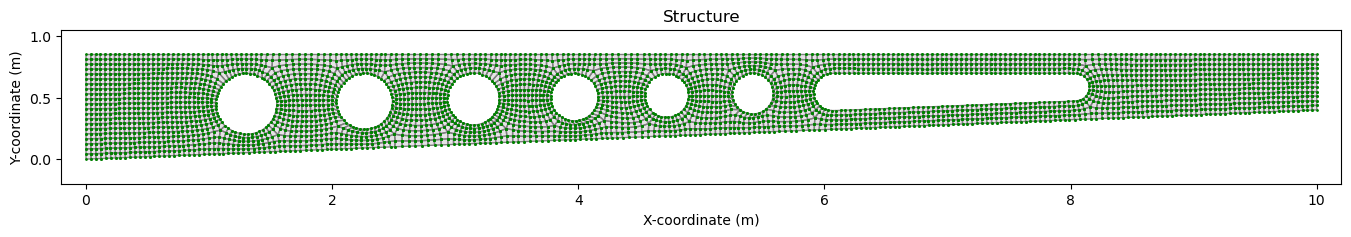

In [ ]:
#plot the structure before proceeding

fig = plt.figure()
axes = fig.add_axes([0.1,0.1,2,1.5])
fig.gca().set_aspect('equal', adjustable='box')

for n, ele in enumerate(elements):

    #Identify node numbers for this elements
    node_1 = ele[0]
    node_2 = ele[1]
    node_3 = ele[2]
    node_4 = ele[3]

    x = np.array([nodes[node_1-1,0],
                  nodes[node_2-1,0],
                  nodes[node_3-1,0],
                  nodes[node_4-1,0]])
    
    y = np.array([nodes[node_1-1,1],
                  nodes[node_2-1,1],
                  nodes[node_3-1,1],
                  nodes[node_4-1,1]])
    
    #Plot 2D patch for each element
    axes.add_patch(patch.Polygon(xy=list(zip(x,y)), facecolor='gray', alpha=0.2)) #patch fill
    axes.add_patch(patch.Polygon(xy=list(zip(x,y)), fill=None, edgecolor='gray', alpha=1)) #patch fill
    axes.plot(x, y,'go', markersize=1)

maxX = nodes.max(0)[0]
maxY = nodes.max(0)[1]
minX = nodes.min(0)[0]
minY = nodes.min(0)[1]
x_margin = 0.2
y_margin = 0.2

axes.set_xlim([minX-x_margin, maxX + x_margin])
axes.set_ylim([minY-y_margin, maxY + y_margin])
axes.set_xlabel('X-coordinate (m)')
axes.set_ylabel('Y-coordinate (m)')
axes.set_title('Structure')
plt.show()

In [ ]:
### Build global force vector and add point forces

forceVector = np.array([np.zeros(len(nodes)*2)]).T

#Add point loads to force vector
if(len(ForceData)>0):
    #Split force location data
    ForceNodes = ForceData[:,0]
    xForceIndices = ForceData[:,1]
    yForceIndices = ForceData[:,2]

    #Assing force to relevant locations within forceVector
    if(pointLoadAxis == 'X'):
        forceVector[xForceIndices] = P
    elif(pointLoadAxis =='Y'):
        forceVector[yForceIndices] = P

        

In [ ]:
#Calculate the element stiffness matrix
#Function to build the 8x8 element stiffness matrix for each element

def calculateKE(alpha, sp, x, y):
    KE = np.zeros([8,8])

    #Sum across all 'r' sample points
    for i, r in enumerate(sp):
        for j, s in enumerate(sp):

            # Partial derivatives of the shape functions
            dhldr = 0.25*(1+s)
            dh2dr = -0.25*(1+s)
            dh3dr = -0.25*(1-s)
            dh4dr = 0.25*(1-s)

            dhlds = 0.25*(1+r)
            dh2ds = 0.25*(1-r)
            dh3ds = -0.25*(1-r)
            dh4ds = -0.25*(1+r)

            # Components of the Jacobian
            dxdr = x[0]*dhldr + x[1]*dh2dr + x[2]*dh3dr + x[3]*dh4dr
            dxds = x[0]*dhlds + x[1]*dh2ds + x[2]*dh3ds + x[3]*dh4ds
            dydr = y[0]*dhldr + y[1]*dh2dr + y[2]*dh3dr + y[3]*dh4dr
            dyds = y[0]*dhlds + y[1]*dh2ds + y[2]*dh3ds + y[3]*dh4ds

            # Calculate the Jacobian, its inverse and determinate
            J = np.matrix([[dxdr, dydr], [dxds, dyds]])
            invJ = J.I
            detJ = np.linalg.det(J)

            # Compile matrices containing partial derivatives of H1 and H2 for calculating B
            dH1 = np.matrix([[dhldr, 0, dh2dr, 0, dh3dr, 0, dh4dr, 0],
                             [dhlds, 0, dh2ds, 0, dh3ds, 0, dh4ds, 0]])

            dH2 = np.matrix([[0, dhldr, 0, dh2dr, 0, dh3dr, 0, dh4dr],
                             [0, dhlds, 0, dh2ds, 0, dh3ds, 0, dh4ds]])

            # Calculate the strain-displacement matrix for this sampling point
            B = np.matrix([[1,0], [0,0], [0,1]])*invJ*dH1 + np.matrix([[0,0], [0,1],[1,0]])*invJ*dH2

            #stiffness matrix contribuition for this sampling point
            KE = KE + alpha[i]*alpha[j]*t*B.T*C*B*detJ

    return KE

In [ ]:
#Build the primary stiffness matrix Kp
#numpy.ix_ for maping and indexing matrices

nDoF = np.amax(elements)*2

KP = np.zeros([nDoF,nDoF])

for n, ele in enumerate(elements):

    #Identify node numbers for this elements
    node_1 = ele[0]
    node_2 = ele[1]
    node_3 = ele[2]
    node_4 = ele[3]

    x = np.array([nodes[node_1-1,0],
                  nodes[node_2-1,0],
                  nodes[node_3-1,0],
                  nodes[node_4-1,0]])
    
    y = np.array([nodes[node_1-1,1],
                  nodes[node_2-1,1],
                  nodes[node_3-1,1],
                  nodes[node_4-1,1]])
    
    KE = calculateKE(alpha, sp, x, y)

    #Primary stiffness matrix indices associated with each node
    i1x =2*node_1-2 #index for horizontal DoF for node 1 (top right)
    i1y =2*node_1-1
    i2x =2*node_2-2
    i2y =2*node_2-1
    i3x =2*node_3-2
    i3y =2*node_3-1
    i4x =2*node_4-2
    i4y =2*node_4-1

    indices = [i1x,i1y,i2x,i2y,i3x,i3y,i4x,i4y]

    #ref: https://numpy.org/doc/stable/reference/generatef/numpy.ix_.html
    indexArray = np.ix_(indices, indices)
    KP[indexArray] = KP[indexArray] + KE

In [ ]:
#Extract the structure stiffness matrix, KS

restrainedIndex = [x-1 for x in RestrainedDoF]

KS = np.delete(KP, restrainedIndex,0) #delete rows
KS = np.delete(KS, restrainedIndex,1) #delete cols
KS = np.matrix(KS) #Convert Ks from numpy.ndarray to numpy.matrix to use built in inverer function

In [ ]:
# Solve for displacements

forceVectorRed = copy.copy(forceVector) # make a copy of forceVector so the copy can be edited
forceVectorRed = np.delete(forceVectorRed, restrainedIndex, 0) #Delete rows corresponding to restrained DoF
U = KS.I*forceVectorRed

In [ ]:
#Solve for reactions
UG = np.zeros(nDoF)

c = 0 #initialize a counter to track how mane restrains have been imposed
for i in np.arange(nDoF):
    
    if i in restrainedIndex:
        #impose a zero displacement
        UG[i] = 0
    else:
        UG[i] = U[c]
        c=c+1

UG = np.array([UG]).T
FG = np.matmul(KP,UG)


C:\Users\DRCurado\AppData\Local\Temp\ipykernel_20652\4195989472.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  UG[i] = U[c]


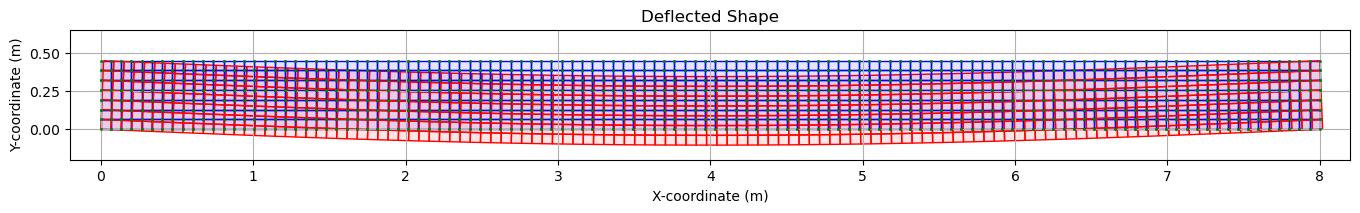

In [ ]:
#Plot the deflected shape

fig = plt.figure()
axes = fig.add_axes([0.1,0.1,2,1.5])
fig.gca().set_aspect('equal', adjustable='box')

dFac = 2 #Deflection scale Factor

for n, ele in enumerate(elements):

    #Identify node numbers for this elements
    node_1 = ele[0]
    node_2 = ele[1]
    node_3 = ele[2]
    node_4 = ele[3]

    #Build an array of x and y coords for this element
    x = np.array([nodes[node_1-1,0],
                  nodes[node_2-1,0],
                  nodes[node_3-1,0],
                  nodes[node_4-1,0]])
    
    y = np.array([nodes[node_1-1,1],
                  nodes[node_2-1,1],
                  nodes[node_3-1,1],
                  nodes[node_4-1,1]])
    
    #Plot 2D patch for each element
    axes.add_patch(patch.Polygon(xy=list(zip(x,y)), facecolor='blue', alpha=0.1)) #patch fill
    axes.add_patch(patch.Polygon(xy=list(zip(x,y)), fill=None, edgecolor='blue', alpha=1)) #patch fill
#    axes.plot(x, y,'go', markersize=1)

    #Primary stiffness matrix indices associated with each node
    i1x =2*node_1-2 #index for horizontal DoF for node 1 (top right)
    i1y =2*node_1-1
    i2x =2*node_2-2
    i2y =2*node_2-1
    i3x =2*node_3-2
    i3y =2*node_3-1
    i4x =2*node_4-2
    i4y =2*node_4-1

    xd = np.array([nodes[node_1-1,0]+UG[i1x,0]*dFac,
                  nodes[node_2-1,0] +UG[i2x,0]*dFac,
                  nodes[node_3-1,0] +UG[i3x,0]*dFac,
                  nodes[node_4-1,0] +UG[i4x,0]*dFac])

    yd = np.array([nodes[node_1-1,1]+UG[i1y,0]*dFac,
                  nodes[node_2-1,1] +UG[i2y,0]*dFac,
                  nodes[node_3-1,1] +UG[i3y,0]*dFac,
                  nodes[node_4-1,1] +UG[i4y,0]*dFac])

    #Plot 2D patch for each element
    axes.add_patch(patch.Polygon(xy=list(zip(xd,yd)), facecolor='red', alpha=0.1)) #patch fill
    axes.add_patch(patch.Polygon(xy=list(zip(xd,yd)), fill=None, edgecolor='red', alpha=1)) #patch fill
    axes.plot(x, y,'go', markersize=1)
    
#Housekeeping
maxX = nodes.max(0)[0]
maxY = nodes.max(0)[1]
minX = nodes.min(0)[0]
minY = nodes.min(0)[1]
x_margin = 0.2
y_margin = 0.2

axes.set_xlim([minX-x_margin, maxX + x_margin])
axes.set_ylim([minY-y_margin, maxY + y_margin])
axes.set_xlabel('X-coordinate (m)')
axes.set_ylabel('Y-coordinate (m)')
axes.set_title('Deflected Shape')
plt.grid()
plt.show()

In [ ]:
#Datailed text output
print('REACTIONS')
print('=================')
for r in RestraintNodes:
    Rx = FG[int(2*r-2)]
    Ry = FG[int(2*r-1)]
    print('-Reaction Fx at node {one}: {two} kN'.format(one = int(r), two=np.round(Rx.item()/1000,2)))
    print('-Reaction Fy at node {one}: {two} kN'.format(one = int(r), two=np.round(Ry.item()/1000,2)))

print('')
print('Nodal Displacement')
print('=================')
for n, node in enumerate(nodes):
    ix = 2*(n+1)-2
    iy = ix+1
    ux = round(UG[ix,0],6)
    uy = round(UG[iy,0],6)
    print("Node {one}: Ux = {two} m, Uy = {three} m".format(one=n+1, two=ux, three=uy))

REACTIONS
-Reaction Fx at node 1: 0.0 kN
-Reaction Fy at node 1: 600.0 kN
-Reaction Fx at node 4: 0.0 kN
-Reaction Fy at node 4: 600.0 kN

Nodal Displacement
Node 1: Ux = 0.0 m, Uy = 0.0 m
Node 2: Ux = 8.4e-05 m, Uy = -0.000152 m
Node 3: Ux = 0.009346 m, Uy = -0.000152 m
Node 4: Ux = 0.009431 m, Uy = 0.0 m
Node 5: Ux = 0.009271 m, Uy = -0.009857 m
Node 6: Ux = 0.009008 m, Uy = -0.019206 m
Node 7: Ux = 0.008598 m, Uy = -0.027835 m
Node 8: Ux = 0.008062 m, Uy = -0.035463 m
Node 9: Ux = 0.007425 m, Uy = -0.04185 m
Node 10: Ux = 0.006707 m, Uy = -0.046806 m
Node 11: Ux = 0.005933 m, Uy = -0.05019 m
Node 12: Ux = 0.005125 m, Uy = -0.051906 m
Node 13: Ux = 0.004306 m, Uy = -0.051906 m
Node 14: Ux = 0.003497 m, Uy = -0.05019 m
Node 15: Ux = 0.002723 m, Uy = -0.046806 m
Node 16: Ux = 0.002006 m, Uy = -0.04185 m
Node 17: Ux = 0.001368 m, Uy = -0.035463 m
Node 18: Ux = 0.000833 m, Uy = -0.027835 m
Node 19: Ux = 0.000423 m, Uy = -0.019206 m
Node 20: Ux = 0.00016 m, Uy = -0.009857 m
Node 21: Ux = 

In [ ]:
#Stress analysis

grid = np.empty((0,5),float)

#Build grid data by cicling through each element
for n, ele in enumerate(elements):

    #Identify node numbers for this elements
    node_1 = ele[0]
    node_2 = ele[1]
    node_3 = ele[2]
    node_4 = ele[3]

    x = np.array([nodes[node_1-1,0],
                  nodes[node_2-1,0],
                  nodes[node_3-1,0],
                  nodes[node_4-1,0]])
    
    y = np.array([nodes[node_1-1,1],
                  nodes[node_2-1,1],
                  nodes[node_3-1,1],
                  nodes[node_4-1,1]])
    
    #Generate data points for each element
    for r in [-1, 0, 1]:
        for s in [-1, 0, 1]:
            
            h1 = 0.25*(1+r)*(1+s)
            h2 = 0.25*(1-r)*(1+s)
            h3 = 0.25*(1-r)*(1-s)
            h4 = 0.25*(1+r)*(1-s)

            xInter = h1*x[0] +h2*x[1] + h3*x[2] + h4*x[3]
            yInter = h1*y[0] +h2*y[1] + h3*y[2] + h4*y[3]
            point = np.array([n, xInter, yInter, r, s])
            grid = np.append(grid, [point], axis=0)

#remove rows with duplicate x and y coords (duplicate datapoints)

e, ind = np.unique(grid[:,[1,2]], return_index=True, axis=0) #extract unique indices based on columns 1 and 2
grid = grid[ind]


print(grid.shape)

(3585, 5)


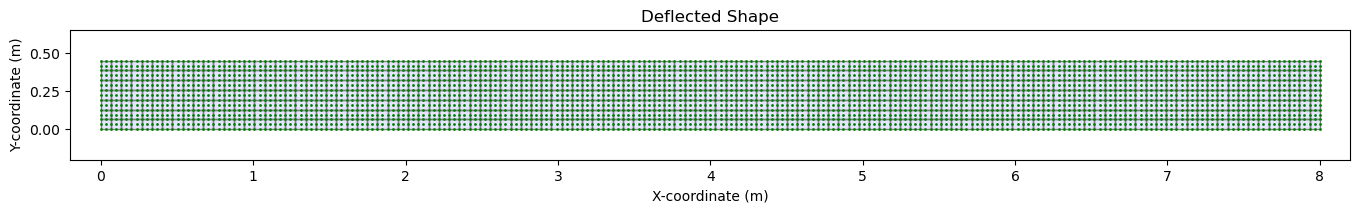

In [ ]:
#Visualize the calculation grid

fig = plt.figure()
axes = fig.add_axes([0.1,0.1,2,1.5])
fig.gca().set_aspect('equal', adjustable='box')

axes.plot(grid[:,1], grid[:,2], 'go', markersize=1) #Datapoints/locations

for n, ele in enumerate(elements):

    #Identify node numbers for this elements
    node_1 = ele[0]
    node_2 = ele[1]
    node_3 = ele[2]
    node_4 = ele[3]

    x = np.array([nodes[node_1-1,0],
                  nodes[node_2-1,0],
                  nodes[node_3-1,0],
                  nodes[node_4-1,0]])
    
    y = np.array([nodes[node_1-1,1],
                  nodes[node_2-1,1],
                  nodes[node_3-1,1],
                  nodes[node_4-1,1]])
    
    #Plot 2D patch for each element
    axes.add_patch(patch.Polygon(xy=list(zip(x,y)), facecolor='blue', alpha=0.1)) #patch fill
    axes.add_patch(patch.Polygon(xy=list(zip(x,y)), fill=None, edgecolor='gray', alpha=1)) #patch fill
#    axes.plot(x, y,'go', markersize=1)

#Housekeeping
maxX = nodes.max(0)[0]
maxY = nodes.max(0)[1]
minX = nodes.min(0)[0]
minY = nodes.min(0)[1]
x_margin = 0.2
y_margin = 0.2

axes.set_xlim([minX-x_margin, maxX + x_margin])
axes.set_ylim([minY-y_margin, maxY + y_margin])
axes.set_xlabel('X-coordinate (m)')
axes.set_ylabel('Y-coordinate (m)')
axes.set_title('Deflected Shape')
plt.show()

In [ ]:
#Calculate the stress and strain at each unique grid point
STRAINS = np.empty((0,3), float) #Strain data
STRESSES = np.empty((0,3), float) #Stress Data
SHEARS =np.empty((0,4), float) #Shear stress/strain data

for n, pt in enumerate(grid):
    #grid point data
    parentNo = int(grid[n,0])
    xGrid = grid[n,1]
    yGrid = grid[n,2]
    r = grid[n,3]
    s = grid[n,4]

    ele = elements[parentNo, :]

    #Identify node numbers for this element
    node_1 = ele[0] #Node number for node 'local 1' (top-right)
    node_2 = ele[1] #Node number for node 'local 2' (top-left)
    node_3 = ele[2] #Node number for node 'local 3' (bottom-left)
    node_4 = ele[3] #Node number for node 'local 4' (bottom-right)

    #Build an array of x and y coords for this element
    x = np.array([nodes[node_1-1,0],
                  nodes[node_2-1,0],
                  nodes[node_3-1,0],
                  nodes[node_4-1,0]])
    
    y = np.array([nodes[node_1-1,1],
                  nodes[node_2-1,1],
                  nodes[node_3-1,1],
                  nodes[node_4-1,1]])

    #Primary stiffness matrix indices associated with each node
    i1x =2*node_1-2 #index for horizontal DoF for node 1 (top right)
    i1y =2*node_1-1
    i2x =2*node_2-2
    i2y =2*node_2-1
    i3x =2*node_3-2
    i3y =2*node_3-1
    i4x =2*node_4-2
    i4y =2*node_4-1

    #Elements nodal displacements
    UE = np.array([[UG[i1x,0], UG[i1y,0], UG[i2x,0], UG[i2y,0], UG[i3x,0], UG[i3y,0], UG[i4x,0], UG[i4y,0]]]).T
    
    # Partial derivatives of the shape functions
    dhldr = 0.25*(1+s)
    dh2dr = -0.25*(1+s)
    dh3dr = -0.25*(1-s)
    dh4dr = 0.25*(1-s)
    
    dhlds = 0.25*(1+r)
    dh2ds = 0.25*(1-r)
    dh3ds = -0.25*(1-r)
    dh4ds = -0.25*(1+r)
    
    # Components of the Jacobian
    dxdr = x[0]*dhldr + x[1]*dh2dr + x[2]*dh3dr + x[3]*dh4dr
    dxds = x[0]*dhlds + x[1]*dh2ds + x[2]*dh3ds + x[3]*dh4ds
    dydr = y[0]*dhldr + y[1]*dh2dr + y[2]*dh3dr + y[3]*dh4dr
    dyds = y[0]*dhlds + y[1]*dh2ds + y[2]*dh3ds + y[3]*dh4ds
    
    # Calculate the Jacobian, its inverse and determinate
    J = np.matrix([[dxdr, dydr], [dxds, dyds]])
    invJ = J.I
    
    # Compile matrices containing partial derivatives of H1 and H2 for calculating B
    dH1 = np.matrix([[dhldr, 0, dh2dr, 0, dh3dr, 0, dh4dr, 0],
                     [dhlds, 0, dh2ds, 0, dh3ds, 0, dh4ds, 0]])
    
    dH2 = np.matrix([[0, dhldr, 0, dh2dr, 0, dh3dr, 0, dh4dr],
                     [0, dhlds, 0, dh2ds, 0, dh3ds, 0, dh4ds]])
    
    # Calculate the strain-displacement matrix for this sampling point
    B = np.matrix([[1,0], [0,0], [0,1]])*invJ*dH1 + np.matrix([[0,0], [0,1],[1,0]])*invJ*dH2
    
    #Calculate the strains and stresses at this location in the grid
    strains = np.matmul(B,UE)
    stresses = np.matmul(C, strains)
    
    #Package and save data
    STRAINS = np.append(STRAINS, strains.reshape(1,3), axis=0)
    STRESSES = np.append(STRESSES, stresses.reshape(1,3), axis=0)
    
    #Only store the value in the center grid point for plot shear
    if((r==0) and (s==0)):
        shears = np.array([xGrid, yGrid, strains[2,0].item(), stresses[2,0].item()])
        SHEARS = np.append(SHEARS, [shears], axis=0)

<>:74: SyntaxWarning: invalid escape sequence '\s'
<>:74: SyntaxWarning: invalid escape sequence '\s'
C:\Users\DRCurado\AppData\Local\Temp\ipykernel_20652\1411129088.py:74: SyntaxWarning: invalid escape sequence '\s'
  axes.set_title('$\sigma_{xx}$ distribution')


(0.0, 0.45)

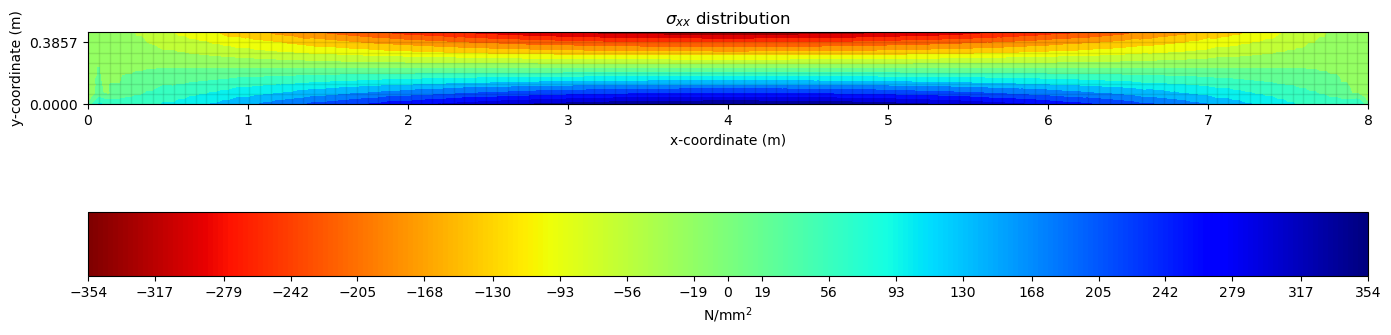

In [ ]:
#Visualize stress field
sig_xx = STRESSES[:,0]*10**-6
sig_yy = STRESSES[:,1]*10**-6
sig_xy = STRESSES[:,2]*10**-6

#Generate target grid to interpolate values to
div = 0.01
xgrid = np.arange(0,8+div, div)
ygrid = np.arange(0,0.45+div, div)
xm, ym = np.meshgrid(xgrid, ygrid)

x = grid[:,1] #Course datapoints
y = grid[:,2] #Course datapoints


z = sig_xx   #interpolate fine datapoints
zi = griddata((x,y),z,(xm,ym), method='linear').squeeze()

#plot data
fig = plt.figure()
axes = fig.add_axes([0.1,0.1,2,1.5])
fig.gca().set_aspect('equal', adjustable='box')

#contour plot
plt.contourf(xm,ym,zi,20)
plt.set_cmap("jet_r")



#Colorbar
norm = matplotlib.colors.TwoSlopeNorm(vmin= z.min(0).item(),
                                      vcenter= 0,
                                      vmax= z.max(0).item())
cmap = plt.cm.jet_r
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)


#Setup colorbar ticks
zMin = int(z.min(0).item())
zMax = int(z.max(0).item())
zDiv = 20
ticks = np.linspace(zMin, zMax, zDiv)
ticks = np.round(np.append(ticks,0))

cbar = fig.colorbar(sm,ax=axes,ticks=ticks,orientation='horizontal')
cbar.set_label('N/mm$^2$')

#plot the grid ontop of the contour plot
for n, ele in enumerate(elements):

    #Identify node numbers for this elements
    node_1 = ele[0]
    node_2 = ele[1]
    node_3 = ele[2]
    node_4 = ele[3]

    x = np.array([nodes[node_1-1,0],
                  nodes[node_2-1,0],
                  nodes[node_3-1,0],
                  nodes[node_4-1,0]])
    
    y = np.array([nodes[node_1-1,1],
                  nodes[node_2-1,1],
                  nodes[node_3-1,1],
                  nodes[node_4-1,1]])
    
        #Plot 2D patch for each element
    axes.add_patch(patch.Polygon(xy=list(zip(x,y)), fill=None, edgecolor='black', alpha=0.05)) #patch fill
#    axes.plot(x, y,'go', markersize=1) #Plot nodes

axes.set_xlabel('x-coordinate (m)')
axes.set_ylabel('y-coordinate (m)')
axes.set_yticks([0,y.max()])
axes.set_title('$\sigma_{xx}$ distribution')
axes.set_xlim([0,8])
axes.set_ylim([0,0.45])


In [ ]:
# notebook widgets to interact with the code

def plotNormalField(Data='Sigma_xx', Resolution= 20):

    sig_xx = STRESSES[:,0]*10**-6
    sig_yy = STRESSES[:,1]*10**-6
    eps_xx = STRAINS[:,0]*10**-6
    eps_yy = STRAINS[:,1]*10**-6

    if(Data=='Sigma_xx'):
        z=sig_xx
    elif(Data=='Sigma_yy'):
        z=sig_yy
    elif(Data=='Epsilon_xx'):
        z=eps_xx
    elif(Data=='Epsilon_yy'):
        z=eps_yy

    #Generate target grid to interpolate values to
    div = 0.01
    xgrid = np.arange(0,8+div, div)
    ygrid = np.arange(0,0.45+div, div)
    xm, ym = np.meshgrid(xgrid, ygrid)

    x = grid[:,1] #Course datapoints
    y = grid[:,2] #Course datapoints

    zi = griddata((x,y),z,(xm,ym), method='linear').squeeze()

    #plot data
    fig = plt.figure()
    axes = fig.add_axes([0.1,0.1,2,1.5])
    fig.gca().set_aspect('equal', adjustable='box')

    #contour plot
    plt.contourf(xm,ym,zi,Resolution)
    plt.set_cmap("jet_r")

    #Colorbar
    norm = matplotlib.colors.TwoSlopeNorm(vmin= z.min(0).item(),
                                          vcenter= 0,
                                          vmax= z.max(0).item())
    cmap = plt.cm.jet_r
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)


    #Setup colorbar ticks
    zMin = int(z.min(0).item())
    zMax = int(z.max(0).item())
    zDiv = Resolution
    ticks = np.linspace(zMin, zMax, zDiv)
    ticks = np.round(np.append(ticks,0))

    cbar = fig.colorbar(sm,ax=axes,ticks=ticks,orientation='horizontal')
    

    #plot the grid ontop of the contour plot
    for n, ele in enumerate(elements):

        #Identify node numbers for this elements
        node_1 = ele[0]
        node_2 = ele[1]
        node_3 = ele[2]
        node_4 = ele[3]

        x = np.array([nodes[node_1-1,0],
                      nodes[node_2-1,0],
                      nodes[node_3-1,0],
                      nodes[node_4-1,0]])

        y = np.array([nodes[node_1-1,1],
                      nodes[node_2-1,1],
                      nodes[node_3-1,1],
                      nodes[node_4-1,1]])

            #Plot 2D patch for each element
        axes.add_patch(patch.Polygon(xy=list(zip(x,y)), fill=None, edgecolor='black', alpha=0.05)) #patch fill
    #    axes.plot(x, y,'go', markersize=1) #Plot nodes

    axes.set_xlabel('x-coordinate (m)')
    axes.set_ylabel('y-coordinate (m)')
    axes.set_yticks([0,y.max()])    
    axes.set_xlim([0,8])
    axes.set_ylim([0,0.45])

    if(Data=='Sigma_xx'):
        axes.set_title('$\sigma_{xx}$ distribution')
        cbar.set_label('N/mm$^2$')
    elif(Data=='Sigma_yy'):
        axes.set_title('$\sigma_{yy}$ distribution')
        cbar.set_label('N/mm$^2$')
    elif(Data=='Epsilon_xx'):
        axes.set_title('$\epsilon_{xx}$ distribution')
        cbar.set_label('$\mu\epsilon$')
    elif(Data=='Epsilon_yy'):
        axes.set_title('$\epsilon_{yy}$ distribution')
        cbar.set_label('$\mu\epsilon$')

    

widgets.interact(plotNormalField,
                 Data = ['Sigma_xx','Sigma_yy','Epsilon_xx','Epsilon_yy'],
                 Resolution = widgets.IntSlider(min=5,max=30,step=5,value=15))

plt.show()

<>:87: SyntaxWarning: invalid escape sequence '\s'
<>:90: SyntaxWarning: invalid escape sequence '\s'
<>:93: SyntaxWarning: invalid escape sequence '\e'
<>:94: SyntaxWarning: invalid escape sequence '\m'
<>:96: SyntaxWarning: invalid escape sequence '\e'
<>:97: SyntaxWarning: invalid escape sequence '\m'
<>:87: SyntaxWarning: invalid escape sequence '\s'
<>:90: SyntaxWarning: invalid escape sequence '\s'
<>:93: SyntaxWarning: invalid escape sequence '\e'
<>:94: SyntaxWarning: invalid escape sequence '\m'
<>:96: SyntaxWarning: invalid escape sequence '\e'
<>:97: SyntaxWarning: invalid escape sequence '\m'
C:\Users\DRCurado\AppData\Local\Temp\ipykernel_20652\2973393688.py:87: SyntaxWarning: invalid escape sequence '\s'
  axes.set_title('$\sigma_{xx}$ distribution')
C:\Users\DRCurado\AppData\Local\Temp\ipykernel_20652\2973393688.py:90: SyntaxWarning: invalid escape sequence '\s'
  axes.set_title('$\sigma_{yy}$ distribution')
C:\Users\DRCurado\AppData\Local\Temp\ipykernel_20652\2973393688.

interactive(children=(Dropdown(description='Data', options=('Sigma_xx', 'Sigma_yy', 'Epsilon_xx', 'Epsilon_yy'…

In [ ]:
#Build shear stress field plot using widgets

def plotShearField(Data='Sigma_xy', Resolution =20):
    eps_xy = SHEARS[:,2]*10**6
    sigma_xy = SHEARS[:,3]*10**-6

    if (Data=='Epsilon_xy'):
        z = eps_xy
    elif(Data=='Sigma_xy'):
       z = sigma_xy

    #Generate target grid to interpolate values to
    div = 0.01
    xgrid = np.arange(0,8+div, div)
    ygrid = np.arange(0,0.45+div, div)
    xm, ym = np.meshgrid(xgrid, ygrid)

    x = SHEARS[:,0] #Course datapoints
    y = SHEARS[:,1] #Course datapoints

    zi = griddata((x,y),z,(xm,ym), method='linear').squeeze()
    
    #plot data
    fig = plt.figure()
    axes = fig.add_axes([0.1,0.1,2,1.5])
    fig.gca().set_aspect('equal', adjustable='box')

    #contour plot
    plt.contourf(xm,ym,zi,Resolution)
    plt.set_cmap("jet_r")

    #Colorbar
    norm = matplotlib.colors.TwoSlopeNorm(vmin= z.min(0).item(),
                                          vcenter= 0,
                                          vmax= z.max(0).item())
    cmap = plt.cm.jet_r
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)


   #Setup colorbar ticks
    zMin = int(z.min(0).item())
    zMax = int(z.max(0).item())
    zDiv = Resolution
    ticks = np.linspace(zMin, zMax, zDiv)
    ticks = np.round(np.append(ticks,0))

    cbar = fig.colorbar(sm,ax=axes,ticks=ticks,orientation='horizontal')
    

    #plot the grid ontop of the contour plot
    for n, ele in enumerate(elements):

        #Identify node numbers for this elements
        node_1 = ele[0]
        node_2 = ele[1]
        node_3 = ele[2]
        node_4 = ele[3]

        x = np.array([nodes[node_1-1,0],
                      nodes[node_2-1,0],
                      nodes[node_3-1,0],
                      nodes[node_4-1,0]])

        y = np.array([nodes[node_1-1,1],
                      nodes[node_2-1,1],
                      nodes[node_3-1,1],
                      nodes[node_4-1,1]])

            #Plot 2D patch for each element
        axes.add_patch(patch.Polygon(xy=list(zip(x,y)), fill=None, edgecolor='black', alpha=0.05)) #patch fill
    #    axes.plot(x, y,'go', markersize=1) #Plot nodes


    axes.set_xlabel('x-coordinate (m)')
    axes.set_ylabel('y-coordinate (m)')
    axes.set_yticks([0,y.max()])    
    axes.set_xlim([0,8])
    axes.set_ylim([0,0.45])

    if(Data=='Sigma_xy'):
        axes.set_title('$\sigma_{xy}$ distribution')
        cbar.set_label('N/mm$^2$')
    elif(Data=='Epsilon_xy'):
        axes.set_title('$\epsilon_{xy}$ distribution')
        cbar.set_label('$\mu\epsilon$')


widgets.interact(plotShearField,
                 Data = ['Sigma_xy', 'Epsilon_xy'],
                 Resolution=(5,30,5))

<>:81: SyntaxWarning: invalid escape sequence '\s'
<>:84: SyntaxWarning: invalid escape sequence '\e'
<>:85: SyntaxWarning: invalid escape sequence '\m'
<>:81: SyntaxWarning: invalid escape sequence '\s'
<>:84: SyntaxWarning: invalid escape sequence '\e'
<>:85: SyntaxWarning: invalid escape sequence '\m'
C:\Users\DRCurado\AppData\Local\Temp\ipykernel_20652\977708497.py:81: SyntaxWarning: invalid escape sequence '\s'
  axes.set_title('$\sigma_{xy}$ distribution')
C:\Users\DRCurado\AppData\Local\Temp\ipykernel_20652\977708497.py:84: SyntaxWarning: invalid escape sequence '\e'
  axes.set_title('$\epsilon_{xy}$ distribution')
C:\Users\DRCurado\AppData\Local\Temp\ipykernel_20652\977708497.py:85: SyntaxWarning: invalid escape sequence '\m'
  cbar.set_label('$\mu\epsilon$')


interactive(children=(Dropdown(description='Data', options=('Sigma_xy', 'Epsilon_xy'), value='Sigma_xy'), IntS…

<function __main__.plotShearField(Data='Sigma_xy', Resolution=20)>